## Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import sys
import lightkurve as lk 
import eleanor
import warnings
import astropy
from astropy.table import Table
from astropy.time import Time
from tqdm import tqdm
from analysis_tools_cython import *
from functools import reduce
import os
warnings.filterwarnings("ignore")
np.set_printoptions(threshold=sys.maxsize)
%matplotlib inline

## Functions 

In [3]:
def import_XRPlightcurve(file_path):
    """
    Importing the compressed TESS lightcurves from the XRP group.
    
    file_path: path to file
    quality: specifies which 
    

    :type file_path: pkl
    :type quality: int or float. 
    """
    data = pd.read_pickle(file_path)

    ## extracting the lightcurve data and converting to Series from lists
    for i in range(len(data)):
        if isinstance(data[i],np.ndarray):
            data[i] = pd.Series(data[i])
    for_df = data[6:] # data[0:6] is not relevant in this case.
    columns = ['time','raw flux','corrected flux','PCA flux','flux error','quality']
    df = pd.DataFrame(data=for_df).T
    df.columns = columns
    table = Table.from_pandas(df)
    return table

def lc_info(file_path):
    data = pd.read_pickle(file_path)
    return data[0:6]
    
def normalise_lc(flux):
    return flux/flux.mean()

def remove_zeros(data):   
    return data[data['PCA flux'] !=0]
    

## First Lightcurve

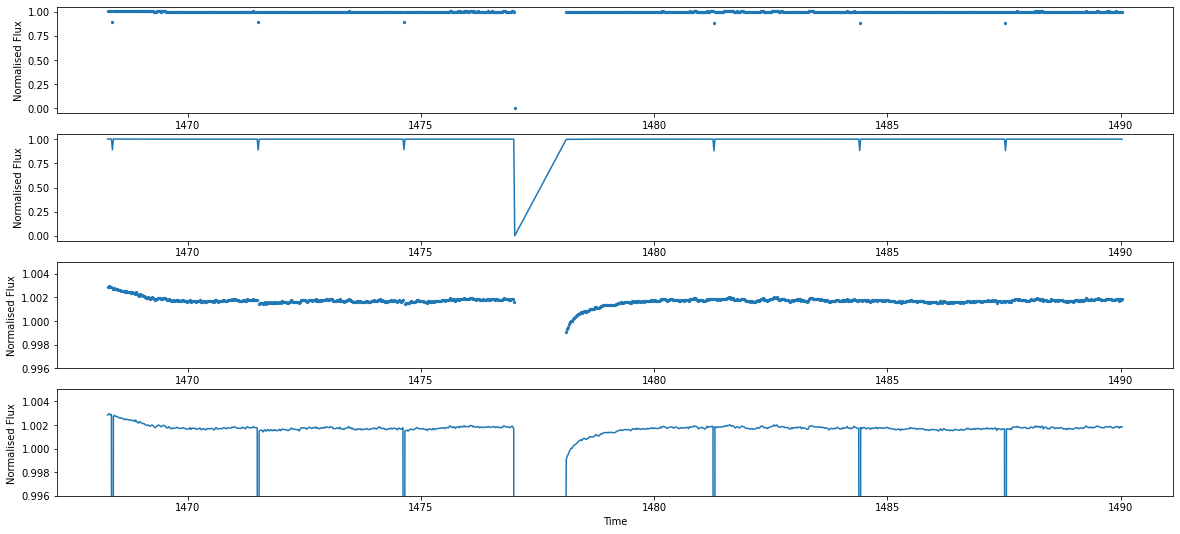

In [4]:
filename = 'tess/tesslcs_sector_6_104_2_min_cadence_targets_tesslc_270577175.pkl'
table = import_XRPlightcurve('tess/tesslcs_sector_6_104_2_min_cadence_targets_tesslc_270577175.pkl')
lc = lc_info(filename)
table['normalised PCA'] = normalise_lc(table['PCA flux'])
to_clean = table[['time','PCA flux','quality']]


fig,ax = plt.subplots(4,figsize=(20,9))
ax[0].scatter(table['time'],table['normalised PCA'],s=5)
ax[1].plot(table['time'],table['normalised PCA'])
ax[2].scatter(table['time'],table['normalised PCA'],s=5)
ax[2].set_ylim([0.996,1.005])
ax[3].plot(table['time'],table['normalised PCA'])
ax[3].set_ylim([0.996,1.005])
for i in ax:  
    i.set_xlabel('Time')
    i.set_ylabel('Normalised Flux')

In [5]:
sys.path.insert(1,'/data')
import data 
import loaders

## MAD

In [6]:
bad_times = data.load_bad_times()
bad_times = bad_times - 2457000
mad_df = data.load_mad()

sec = int(os.path.basename(filename).split('_')[2])
cam = lc[4]
mad_arr = mad_df.loc[:len(table)-1, f"{sec}-{cam}"]
mad_cut = mad_arr.values<(np.nanmedian(mad_arr)+10*np.std(mad_arr[900:950]))
mask = np.ones_like(table['time'], dtype=bool)
for i in bad_times:
    newchunk = (table['time']<i[0])|(table['time']>i[1])
    mask = mask & newchunk

### Beta Pic Only

In [7]:
new_lc = table[(table['quality']==0) & mask & mad_cut]
new_lc_all_flags = table[((table['quality']==0) | (table['quality']!=0)) & mask & mad_cut]

#### removing zero points (if any - see Beta Pic)

In [8]:
test_lc = remove_zeros(new_lc)
test_lc = test_lc['time','normalised PCA','quality']
test_lc_all_flags = remove_zeros(new_lc_all_flags)
test_lc_all_flags = test_lc_all_flags['time','normalised PCA','quality']

---

## Lightkurve

Objects of interest:

- "Beta Pictoris"
- "KIC 3542116"
- "KIC 11084727"

In [9]:
tpf = lk.search_targetpixelfile("Beta Pictoris", mission='TESS',sector=6).download()

In [10]:
tpf.interact()

## Automated Search

#### Running the algorithm

Maximum transit chance:
   Time = 1483.1 days.
   Duration = 0.44 days.
   T (signal) = -5.5
   T/sigma (signal-to-noise) = -2.8
Transit depth = -0.0
[7.003686019511474e-07, 6.836201721439272e-07]
Asym score: 1.0245
Quality flags: 0.0
maybeTransit


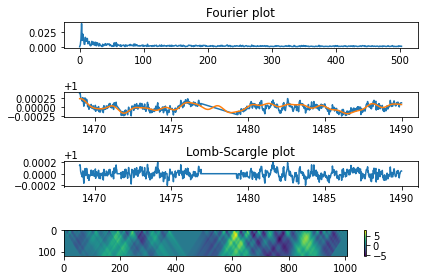

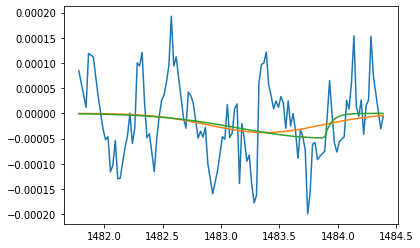

In [11]:
timestep = calculate_timestep(table) # median value of time differences between data points
t, flux, quality, real = clean_data(test_lc)
N = len(t) # length of data (time)
ones = np.ones(N) # array of ones

flux = normalise_flux(flux) # normalised flux - need to(?)

# periodic noise removal with fourier
filteredflux = fourier_filter(flux, 8)
A_mag = np.abs(np.fft.rfft(flux))
periodicnoise = flux - filteredflux
sigma = flux.std()

# periodic noise removal with lomb-scargle
flux_ls = np.copy(flux)
lombscargle_filter(t, flux_ls, real, 0.05) 
periodicnoise_ls = flux - flux_ls # removing periodic noise = flux - flux_ls ( the cleaned lc) 
flux_ls = flux_ls * real # real: interpolated data assumed to be real

T1 = test_statistic_array(filteredflux, 60) # fourier test statistic
T = test_statistic_array(flux_ls, 60) # lomb-scargle test statistic
data = nonzero(T) # all non zeroes

# Find minimum test statistic value, and its location.
m, n = np.unravel_index(T.argmin(), T.shape) # gives index of minimum T (m), and index of minimum T (n) - the element of the shape (so here, 1145) 
minT = T[m, n] # T test result - the most negative value of T - strongest event in lightcurve.
minT_time = t[n] # period of transit
minT_duration = m * timestep # duration of transit
print("Maximum transit chance:")
print("   Time =", round(minT_time, 2), "days.") # 
print("   Duration =", round(minT_duration, 2), "days.") # box duration of transit
print("   T (signal) =", round(minT, 1)) # minimum test statistic (signal)
print("   T/sigma (signal-to-noise) =", round(minT / data.std(), 1)) # strongest signal / std of all n and w considered

trans_start = n - math.floor((m - 1) / 2) # (1145-(1-1)/2): half width - math.floor rounds down
trans_end = trans_start + m 
print("Transit depth =", round(flux[trans_start:trans_end].mean(), 6))

# Transit shape calculation
if n - 3 * m >= 0 and n + 3 * m < N: # m: width of point(s) in lc. first part: 3 transit widths away from first data point. last part: not more than 3 transit widths away. 
    t2 = t[n - 3 * m:n + 3 * m] #time array
    x2 = flux_ls[n - 3 * m:n + 3 * m] #flux array
    q2 = quality[n - 3 * m:n + 3 * m] 
    background = (sum(x2[:1 * m]) + sum(x2[5 * m:])) / (2 * m)
    x2 -= background 
    paramsgauss = single_gaussian_curve_fit(t2, -x2) #gaussian curve
    y2 = -gauss(t2, *paramsgauss) # simple gaussian model fit
    paramscomet = comet_curve_fit(t2, -x2)
    w2 = -comet_curve(t2, *paramscomet) # modified gaussian model fit with exponential tail

    scores = [score_fit(x2, fit) for fit in [y2, w2]]
    print(scores)
    print("Asym score:", round(scores[0] / scores[1], 4))

    qual_flags = reduce(lambda a, b: a or b, q2)
    print("Quality flags:", qual_flags)

# Classify events
asym, _, _ = calc_shape(m, n, t, flux) # plot 
print(classify(m, n, real, asym))

# Skip plotting if no graphical output set
# if args.n:
#     sys.exit()

# plt.xkcd()
fig1, axarr = plt.subplots(4)
axarr[0].plot(A_mag) # fourier plot
axarr[0].title.set_text('Fourier plot')
axarr[1].plot(t, flux + ones, t, periodicnoise_ls + ones) #
axarr[2].plot(t, flux_ls + ones) # lomb-scargle plot
axarr[2].title.set_text('Lomb-Scargle plot') 
cax = axarr[3].imshow(T)
axarr[3].set_aspect('auto')
fig1.colorbar(cax)

# params = double_gaussian_curve_fit(T)
fig2 = plt.figure()
ax2 = fig2.add_subplot(111)
# T_test_nonzero = np.array(data)
# _,bins,_ = ax2.hist(T_test_nonzero,bins=100,log=True)
# y = np.maximum(bimodal(bins,*params),10)
# ax2.plot(bins,y)
try:
    ax2.plot(t2, x2, t2, y2, t2, w2)
 
except:
    pass

fig1.tight_layout()
plt.show()

---

## Eleanor

In [12]:
import eleanor

In [13]:
eleanor.Update(sector=6)

AttributeError: module 'eleanor' has no attribute 'Update'

In [ ]:
star = eleanor.Source(tic=270577175,sector=6)

In [ ]:
data = eleanor.TargetData(star,do_pca=True)

In [ ]:
from matplotlib import pyplot as plt
import numpy as np

In [ ]:
plt.imshow(data.post_obj.background2d[100],vmin=0,vmax=20)

In [ ]:
q = data.quality == 0

plt.figure(figsize=(25,8))
plt.scatter(data.time[q],data.pca_flux[q]/np.nanmedian(data.pca_flux[q]),s=5)
plt.title("")
plt.show()

Linear interpolation code is not present (page 4) - update on github.